# K-Wave Data Validation & Debugging

Mirrors the IC debugging workflow:
1. **Inspect** raw HDF5 structure and catch NaNs early
2. **Sanity-check** GT images and measurements visually
3. **Direct GT supervision** — no L-matrix, just overfit to slowness map
4. **Forward model** — plug in L-matrix, verify residual is finite
5. **Full reconstruction** — engine call, check loss curve and output

---
## 0 — Imports & paths

In [78]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import inr_sos
from inr_sos import DATA_DIR

# ── Paths ──────────────────────────────────────────────────────────────────
KWAVE_GEOM_PATH = DATA_DIR + "/DL-based-SoS/test_kWaveGeom_l2rec_l1rec_unifiedvar.mat"
KWAVE_BLOB_PATH = DATA_DIR + "/DL-based-SoS/test_kWaveBlob_final.mat"
GRID_PATH       = DATA_DIR + "/DL-based-SoS/forward_model_lr/grid_parameters.mat"
L_PATH          = DATA_DIR + "/DL-based-SoS/forward_model_lr/L.mat"

# Work with geom first (has embedded A matrix)
DATA_PATH  = KWAVE_GEOM_PATH
SAMPLE_IDX = 2   # change freely

print("torch:", torch.__version__)
print("CUDA: ", torch.cuda.is_available())

torch: 2.10.0+cu128
CUDA:  True


---
## 1 — Raw HDF5 inspection
Confirm keys, shapes, and whether measurements contain NaNs.

In [79]:
inr_sos.io.utils.inspect_mat_fileheader(DATA_PATH)


[HDF5 Format Detected]
  Key: 'A' | Type: Group
  Key: 'A/data' | Shape: (74580122,) | Type: Dataset
  Key: 'A/ir' | Shape: (74580122,) | Type: Dataset
  Key: 'A/jc' | Shape: (4097,) | Type: Dataset
  Key: 'MaskSoS' | Shape: (8, 128, 128) | Type: Dataset
  Key: 'all_correlation_vector' | Shape: (32, 131072) | Type: Dataset
  Key: 'all_slowness_recons_l1' | Shape: (32, 64, 64) | Type: Dataset
  Key: 'all_slowness_recons_l2' | Shape: (32, 64, 64) | Type: Dataset
  Key: 'bf_sos' | Shape: (1, 1) | Type: Dataset
  Key: 'imgs_gt' | Shape: (32, 64, 64) | Type: Dataset
  Key: 'measmnts' | Shape: (32, 131072) | Type: Dataset
  Key: 'nanidx' | Shape: (32, 131072) | Type: Dataset
  Key: 'pix2time' | Shape: (1, 1) | Type: Dataset
  Key: 'reg_param' | Shape: (1, 1) | Type: Dataset


In [80]:
with h5py.File(DATA_PATH, 'r') as f:
    measmnts = np.array(f['measmnts'][SAMPLE_IDX])   # (131072,)
    nanidx   = np.array(f['nanidx'][SAMPLE_IDX])     # (131072,)  1=invalid
    imgs_gt  = np.array(f['imgs_gt'][SAMPLE_IDX])    # (64, 64)

print(f"measmnts  shape : {measmnts.shape}")
print(f"nanidx    shape : {nanidx.shape}")
print(f"imgs_gt   shape : {imgs_gt.shape}")
print()

nan_in_meas = int(np.isnan(measmnts).sum())
nan_marked  = int(nanidx.sum())      # positions flagged by nanidx

print(f"NaN values in measmnts     : {nan_in_meas}")
print(f"Positions flagged by nanidx: {nan_marked}")
print(f"NaN count matches nanidx   : {nan_in_meas == nan_marked}")
print()

# Valid measurements only
mask_bool  = nanidx == 0
valid_meas = measmnts[mask_bool]
print(f"Valid measurement count : {mask_bool.sum()}")
print(f"Valid meas range        : [{valid_meas.min():.4e}, {valid_meas.max():.4e}]")
print(f"Valid meas mean / std   : {valid_meas.mean():.4e} / {valid_meas.std():.4e}")

# GT slowness stats
print()
print(f"GT slowness range  : [{imgs_gt.min():.6e}, {imgs_gt.max():.6e}]")
print(f"GT SoS range (m/s) : [{1/imgs_gt.max():.1f}, {1/imgs_gt.min():.1f}]")

measmnts  shape : (131072,)
nanidx    shape : (131072,)
imgs_gt   shape : (64, 64)

NaN values in measmnts     : 59512
Positions flagged by nanidx: 59512
NaN count matches nanidx   : True

Valid measurement count : 71560
Valid meas range        : [-8.4125e-07, 8.4872e-07]
Valid meas mean / std   : 3.9272e-09 / 3.8554e-07

GT slowness range  : [6.451613e-04, 6.666667e-04]
GT SoS range (m/s) : [1500.0, 1550.0]


### 1b — pix2time and other metadata

`pix2time` is the unit-conversion scalar that calibrates `time_scale` in the engines.  
For the IC data `time_scale=1e6` was hardcoded. Here we read it from the file.

In [81]:
with h5py.File(DATA_PATH, 'r') as f:
    print("Top-level keys:", list(f.keys()))
    print()
    for key in ['pix2time', 'bf_sos', 'reg_param']:
        if key in f:
            val = float(np.array(f[key]).flat[0])
            print(f"  {key} = {val:.6e}")
        else:
            print(f"  {key} : NOT PRESENT")

Top-level keys: ['A', 'MaskSoS', 'all_correlation_vector', 'all_slowness_recons_l1', 'all_slowness_recons_l2', 'bf_sos', 'imgs_gt', 'measmnts', 'nanidx', 'pix2time', 'reg_param']

  pix2time = 4.966887e-08
  bf_sos = 1.510000e+03
  reg_param = 1.000000e-01


---
## 2 — Visual sanity check of raw data

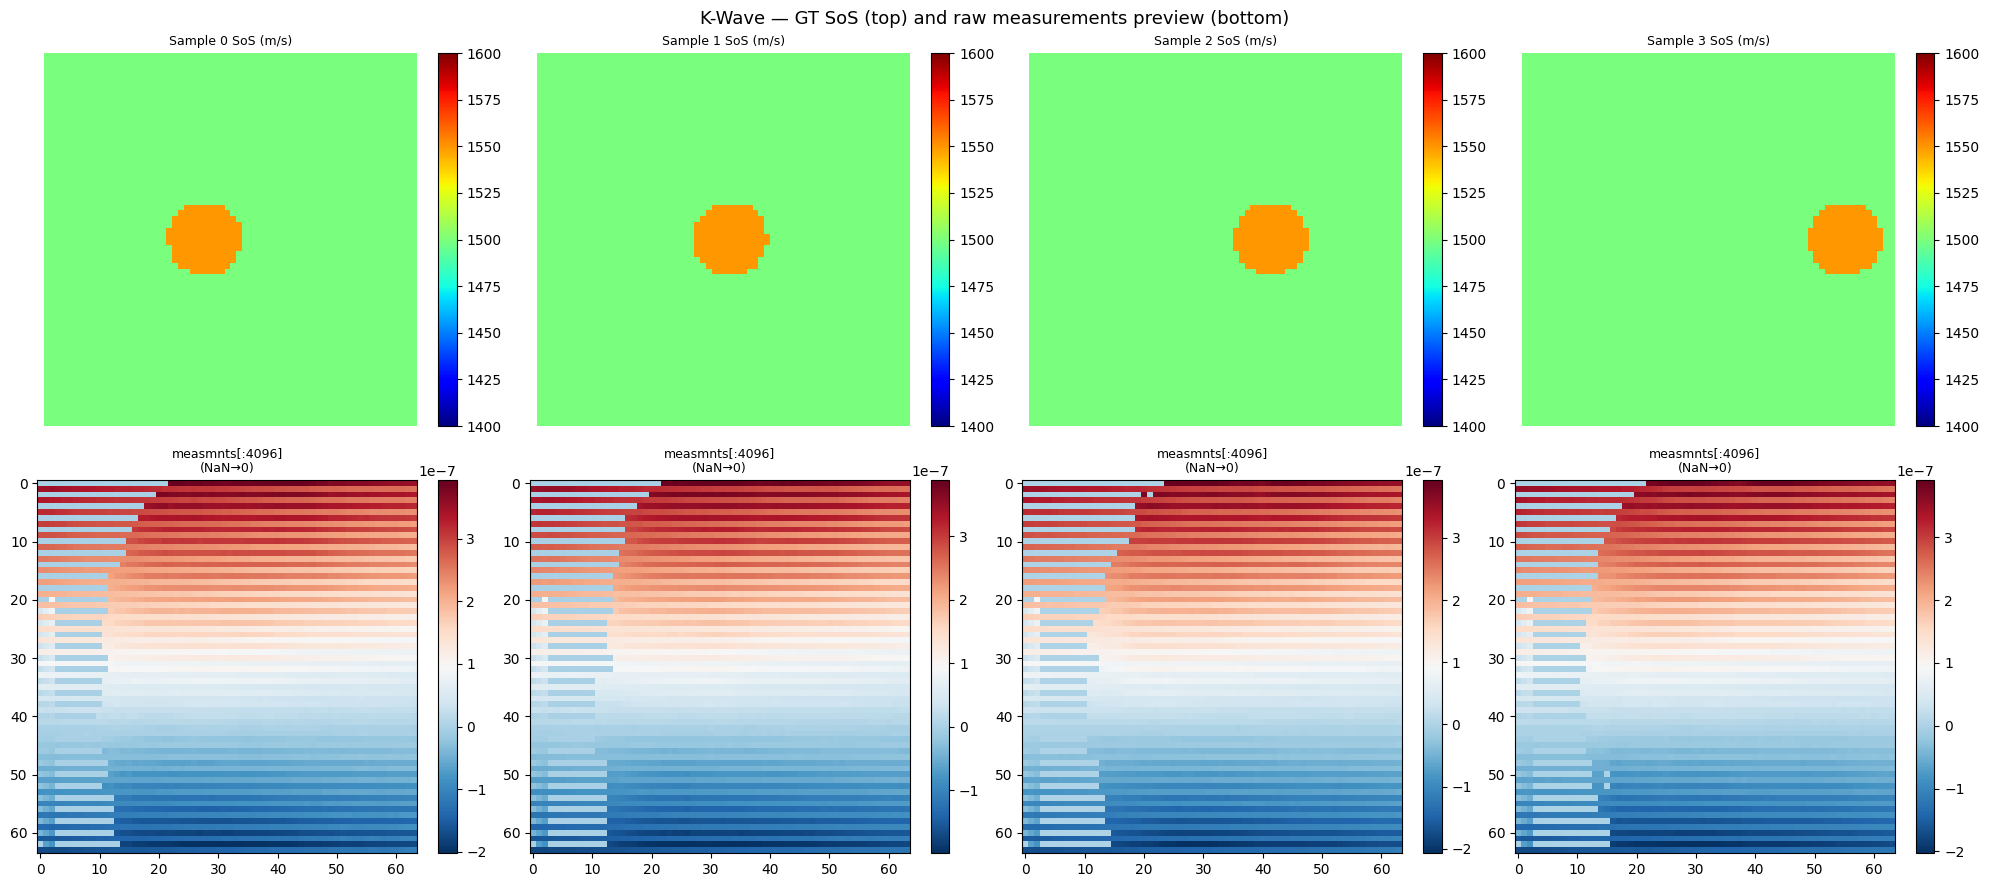

In [82]:
with h5py.File(DATA_PATH, 'r') as f:
    n_samples = f['imgs_gt'].shape[0]

n_show = min(4, n_samples)
fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 9))
fig.suptitle("K-Wave — GT SoS (top) and raw measurements preview (bottom)", fontsize=13)

with h5py.File(DATA_PATH, 'r') as f:
    for col in range(n_show):
        gt   = np.array(f['imgs_gt'][col])
        meas = np.array(f['measmnts'][col])
        nidx = np.array(f['nanidx'][col])

        v_gt = 1.0 / (gt + 1e-8)
        ax_gt = axes[0, col]
        im = ax_gt.imshow(v_gt, cmap='jet', vmin=1400, vmax=1600)
        ax_gt.set_title(f"Sample {col} SoS (m/s)", fontsize=9)
        ax_gt.axis('off')
        plt.colorbar(im, ax=ax_gt, fraction=0.046)

        # Zero NaNs for display
        meas_display = np.where(nidx == 0, meas, 0.0)
        ax_m = axes[1, col]
        im2  = ax_m.imshow(meas_display[:4096].reshape(64, 64),
                            cmap='RdBu_r', aspect='auto')
        ax_m.set_title(f"measmnts[:4096]\n(NaN→0)", fontsize=9)
        plt.colorbar(im2, ax=ax_m, fraction=0.046)

plt.tight_layout()
plt.show()

---
## 3 — Load via USDataset and verify NaN fix

In [84]:
from inr_sos.utils.data import USDataset

dataset = USDataset(DATA_PATH, GRID_PATH)
print(f"Dataset length   : {len(dataset)}")
print(f"L_matrix shape   : {dataset.L_matrix.shape}")
print(f"L_matrix has NaN : {torch.isnan(dataset.L_matrix).any().item()}")
print(f"pix2time         : {dataset.pix2time}")

Dataset length   : 32
L_matrix shape   : torch.Size([131072, 4096])
L_matrix has NaN : False
pix2time         : 4.966887417218542e-08


In [85]:
sample = dataset[SAMPLE_IDX]

print("── Sample keys and shapes ──────────────────────────")
for k, v in sample.items():
    if hasattr(v, 'shape'):
        print(f"  {k:<22} shape={tuple(v.shape)}  dtype={v.dtype}")
    elif isinstance(v, tuple):
        print(f"  {k:<22} = ({v[0].item():.4e}, {v[1].item():.4e})")
    else:
        print(f"  {k:<22} = {v}")

print()
print("── NaN checks ──────────────────────────────────────")
print(f"  d_meas NaNs   : {torch.isnan(sample['d_meas']).sum().item()}")
print(f"  s_gt_raw NaNs : {torch.isnan(sample['s_gt_raw']).sum().item()}")
print(f"  mask zeros    : {(sample['mask'] == 0).sum().item()}  (invalid)")
print(f"  mask ones     : {(sample['mask'] == 1).sum().item()}  (valid)")
print()

d = sample['d_meas']
valid_mask = sample['mask'].squeeze().bool()
d_valid    = sample['d_meas'].squeeze()[valid_mask]
print(f"── d_meas stats (valid entries) ────────────────────")
print(f"  min={d_valid.min():.4e}  max={d_valid.max():.4e}")
print(f"  mean={d_valid.mean():.4e}  std={d_valid.std():.4e}")

── Sample keys and shapes ──────────────────────────
  coords                 shape=(4096, 2)  dtype=torch.float32
  s_gt_raw               shape=(4096, 1)  dtype=torch.float32
  s_gt_normalized        shape=(4096, 1)  dtype=torch.float32
  s_stats                = (6.6601e-04, 3.7138e-06)
  d_meas                 shape=(131072, 1)  dtype=torch.float32
  mask                   shape=(131072, 1)  dtype=torch.float32
  L_matrix               shape=(131072, 4096)  dtype=torch.float32
  idx                    = 2
  s_l1_recon             shape=(4096, 1)  dtype=torch.float32
  s_l2_recon             shape=(4096, 1)  dtype=torch.float32
  correlation            shape=(32, 1)  dtype=torch.float32

── NaN checks ──────────────────────────────────────
  d_meas NaNs   : 0
  s_gt_raw NaNs : 0
  mask zeros    : 59512  (invalid)
  mask ones     : 71560  (valid)

── d_meas stats (valid entries) ────────────────────
  min=-8.4125e-07  max=8.4872e-07
  mean=3.9273e-09  std=3.8555e-07


---
## 4 — Direct GT supervision (no L-matrix)

Same as IC baseline: teach the INR to memorise the GT slowness map directly.  
**Expected:** finite decreasing loss, visual match to GT.  
**If NaN here:** problem is upstream (coords, model init, GT values).

In [86]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from inr_sos.models.siren import SirenMLP
from inr_sos.models.mlp import ReluMLP, FourierMLP

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
STEPS  = 1000

model_gt   = ReluMLP(in_features=2, hidden_features=256, hidden_layers=3).to(DEVICE)
coords_dev = sample['coords'].to(DEVICE)              # (4096, 2)
s_gt_n     = sample['s_gt_normalized'].to(DEVICE)     # (4096, 1)
s_mean     = sample['s_stats'][0].item()
s_std      = sample['s_stats'][1].item()

optimizer    = optim.Adam(model_gt.parameters(), lr=1e-3)
loss_fn      = nn.MSELoss()
gt_losses    = []

pbar = tqdm(range(STEPS))
for step in pbar:
    optimizer.zero_grad()
    s_norm = model_gt(coords_dev)
    loss   = loss_fn(s_norm, s_gt_n)
    loss.backward()
    optimizer.step()
    gt_losses.append(loss.item())
    if step % 100 == 0:
        pbar.set_description(f"GT-sup loss: {loss.item():.4e}")
    if torch.isnan(loss):
        print(f"\n❌  NaN at step {step}"); break

print(f"\nFinal loss : {gt_losses[-1]:.4e}")
print(f"Any NaN    : {any(np.isnan(v) for v in gt_losses)}")

GT-sup loss: 1.8672e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 849.82it/s]


Final loss : 3.9048e-05
Any NaN    : False


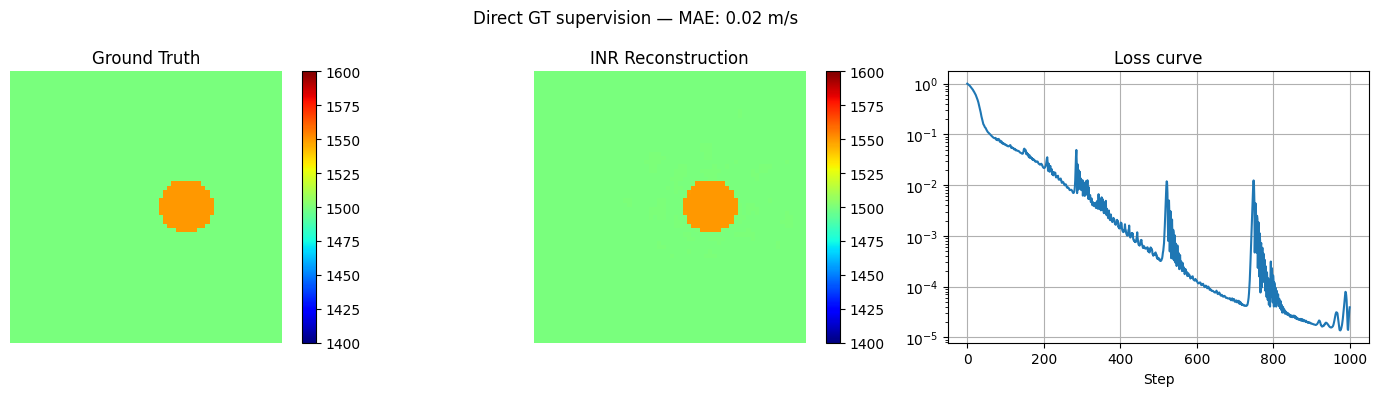

In [88]:
model_gt.eval()
with torch.no_grad():
    s_norm = model_gt(coords_dev)
    s_phys = (s_norm * s_std + s_mean).cpu().numpy().reshape(64, 64)

v_pred = 1.0 / (s_phys + 1e-8)
v_gt   = 1.0 / (sample['s_gt_raw'].numpy().reshape(64, 64) + 1e-8)
mae    = np.abs(v_pred - v_gt).mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Direct GT supervision — MAE: {mae:.2f} m/s", fontsize=12)

im0 = axes[0].imshow(v_gt,                cmap='jet', vmin=1400, vmax=1600)
im1 = axes[1].imshow(np.clip(v_pred, 1400, 1600), cmap='jet', vmin=1400, vmax=1600)
axes[0].set_title("Ground Truth");         axes[0].axis('off'); plt.colorbar(im0, ax=axes[0], fraction=0.046)
axes[1].set_title("INR Reconstruction");   axes[1].axis('off'); plt.colorbar(im1, ax=axes[1], fraction=0.046)
axes[2].plot(gt_losses); axes[2].set_yscale('log')
axes[2].set_xlabel('Step'); axes[2].set_title('Loss curve'); axes[2].grid(True)
plt.tight_layout(); plt.show()

---
## 5 — Forward model sanity check (before optimisation)

Compute `L @ s_gt_raw` and compare against `d_meas`.  
This tells us the correct `time_scale` and confirms the residual is finite.

In [89]:
L      = dataset.L_matrix          # (131072, 4096)
s_gt_r = sample['s_gt_raw']       # (4096, 1)
d_meas = sample['d_meas']         # (131072, 1) — NaNs already zeroed
mask   = sample['mask']           # (131072, 1)

print(f"L shape         : {L.shape}")
print(f"L has NaN       : {torch.isnan(L).any().item()}")
print(f"L has Inf       : {torch.isinf(L).any().item()}")
print()

with torch.no_grad():
    d_pred   = L @ s_gt_r
    residual = (d_pred - d_meas) * mask

valid_mask_bool = mask.squeeze().bool()
d_pred_valid    = d_pred.squeeze()[valid_mask_bool]
d_meas_valid    = d_meas.squeeze()[valid_mask_bool]
resid_valid     = residual.squeeze()[valid_mask_bool]

print(f"d_pred  (GT input) range : [{d_pred_valid.min():.4e}, {d_pred_valid.max():.4e}]")
print(f"d_meas  (measured) range : [{d_meas_valid.min():.4e}, {d_meas_valid.max():.4e}]")
print(f"residual           range : [{resid_valid.min():.4e}, {resid_valid.max():.4e}]")
print()

rms_raw = resid_valid.pow(2).mean().sqrt().item()
print(f"RMS residual (raw)       : {rms_raw:.4e}")
print(f"Ideal time_scale (→ loss≈1): {1.0/rms_raw:.4e}")

if dataset.pix2time is not None:
    print()
    print(f"pix2time from file       : {dataset.pix2time:.4e}")
    print(f"1/pix2time               : {1.0/dataset.pix2time:.4e}")
    scale_candidate = 1.0 / dataset.pix2time
    print(f"loss with 1/pix2time     : {(rms_raw * scale_candidate)**2:.4e}")

L shape         : torch.Size([131072, 4096])
L has NaN       : False
L has Inf       : False

d_pred  (GT input) range : [-8.1206e-07, 8.1508e-07]
d_meas  (measured) range : [-8.4125e-07, 8.4872e-07]
residual           range : [-6.9366e-08, 1.0413e-07]

RMS residual (raw)       : 1.0360e-08
Ideal time_scale (→ loss≈1): 9.6521e+07

pix2time from file       : 4.9669e-08
1/pix2time               : 2.0133e+07
loss with 1/pix2time     : 4.3510e-02


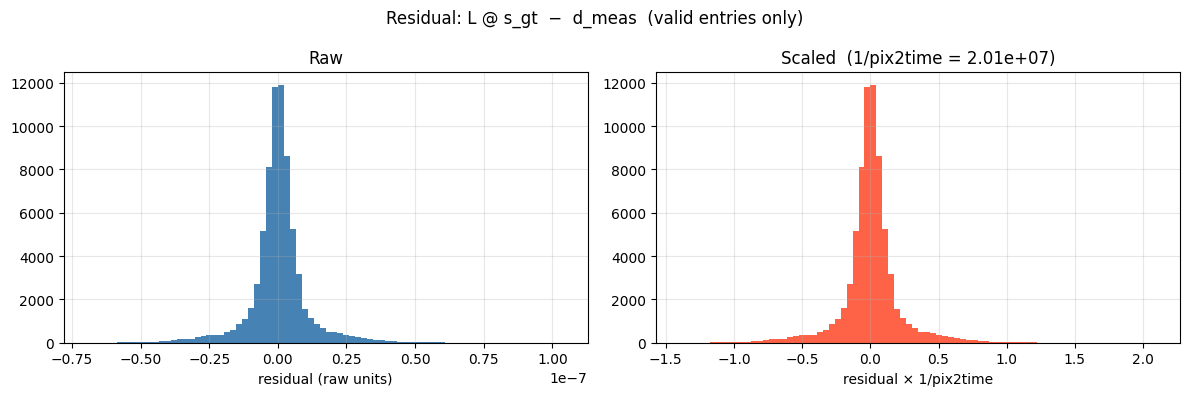

In [90]:
# Histogram: raw residual vs scaled residual
res_np = resid_valid.numpy()

scale_label = "1/pix2time" if dataset.pix2time else "1e6 (IC default)"
scale_val   = (1.0/dataset.pix2time) if dataset.pix2time else 1e6

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Residual: L @ s_gt  −  d_meas  (valid entries only)", fontsize=12)

axes[0].hist(res_np, bins=80, color='steelblue', edgecolor='none')
axes[0].set_xlabel('residual (raw units)'); axes[0].set_title('Raw')

axes[1].hist(res_np * scale_val, bins=80, color='tomato', edgecolor='none')
axes[1].set_xlabel(f'residual × {scale_label}')
axes[1].set_title(f'Scaled  ({scale_label} = {scale_val:.2e})')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

---
## 6 — Single-step loss check with random model

Before running any loop, verify the loss is **finite** at step 0.

In [91]:
# Pick the time_scale
if dataset.pix2time is not None:
    TIME_SCALE = 1.0 / dataset.pix2time
else:
    TIME_SCALE = 1e6   # IC fallback
print(f"time_scale = {TIME_SCALE:.4e}")

model_check = ReluMLP(in_features=2, hidden_features=256, hidden_layers=3).to(DEVICE)
L_dev       = dataset.L_matrix.to(DEVICE)
d_dev       = sample['d_meas'].to(DEVICE)
mask_dev    = sample['mask'].to(DEVICE)

with torch.no_grad():
    s_norm   = model_check(coords_dev)
    s_phys   = s_norm * s_std + s_mean
    d_pred   = L_dev @ s_phys
    residual = (d_pred - d_dev) * mask_dev
    loss     = ((residual * TIME_SCALE) ** 2).sum() / (mask_dev.sum() + 1e-8)

print(f"s_phys range     : [{s_phys.min():.4e}, {s_phys.max():.4e}]")
print(f"d_pred range     : [{d_pred.min():.4e}, {d_pred.max():.4e}]")
print(f"residual has NaN : {torch.isnan(residual).any().item()}")
print(f"residual has Inf : {torch.isinf(residual).any().item()}")
print(f"loss  (step 0)   : {loss.item():.4e}")
print()

if torch.isnan(loss):
    print("❌  Loss is NaN — tracing source:")
    print(f"   NaN in d_pred   : {torch.isnan(d_pred).sum().item()}")
    print(f"   NaN in d_meas   : {torch.isnan(d_dev).sum().item()}  ← >0 means nan_to_num fix needed")
    print(f"   NaN in residual : {torch.isnan(residual).sum().item()}")
else:
    print("✅  Loss is finite — safe to run optimisation loop")

time_scale = 2.0133e+07
s_phys range     : [6.6572e-04, 6.6582e-04]
d_pred range     : [-1.2209e-06, 1.2156e-06]
residual has NaN : False
residual has Inf : False
loss  (step 0)   : 4.4484e-02

✅  Loss is finite — safe to run optimisation loop


---
## 7 — Short optimisation loop with the forward model

200 steps. Watch:
- **Finite & decreasing** → all clear, time_scale is correct
- **NaN from step 0** → d_meas still has NaNs
- **Explodes then NaN** → time_scale too large, reduce it

In [92]:
SHORT_STEPS = 200

model_fwd = ReluMLP(in_features=2, hidden_features=256, hidden_layers=3).to(DEVICE)
optimizer = optim.Adam(model_fwd.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SHORT_STEPS)
fwd_losses = []

pbar = tqdm(range(SHORT_STEPS))
for step in pbar:
    model_fwd.train()
    optimizer.zero_grad()

    s_norm   = model_fwd(coords_dev)
    s_phys   = s_norm * s_std + s_mean
    d_pred   = L_dev @ s_phys
    residual = (d_pred - d_dev) * mask_dev
    loss     = ((residual * TIME_SCALE) ** 2).sum() / (mask_dev.sum() + 1e-8)

    loss.backward()
    optimizer.step()
    scheduler.step()

    fwd_losses.append(loss.item())
    if step % 50 == 0:
        pbar.set_description(f"Fwd loss: {loss.item():.4e}")
    if torch.isnan(loss):
        print(f"\n❌  NaN at step {step}"); break

print(f"\nFinal loss : {fwd_losses[-1]:.4e}")
print(f"NaN steps  : {sum(1 for v in fwd_losses if np.isnan(v))} / {len(fwd_losses)}")

Fwd loss: 1.8755e-02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 120.07it/s]


Final loss : 1.8542e-02
NaN steps  : 0 / 200


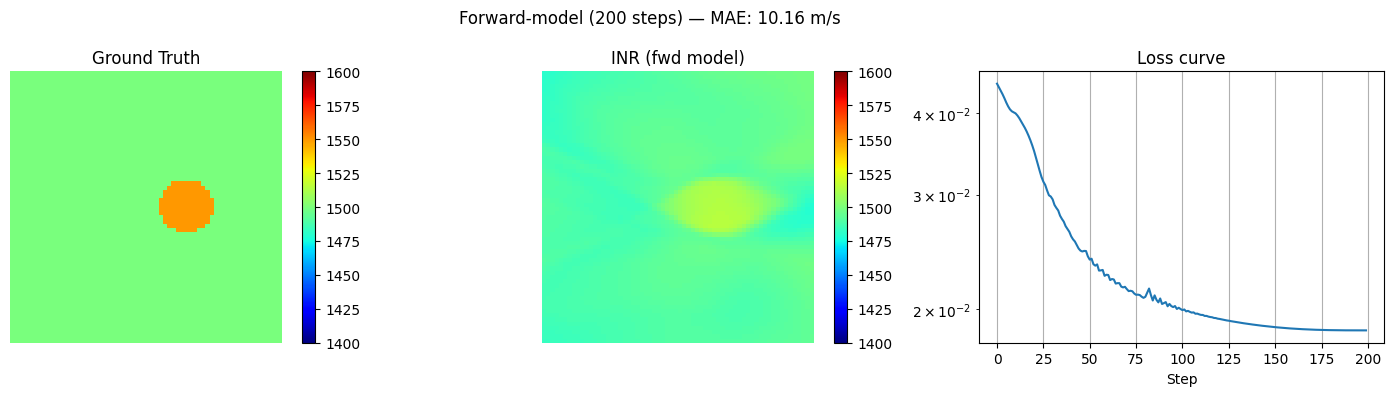

In [93]:
model_fwd.eval()
with torch.no_grad():
    s_norm = model_fwd(coords_dev)
    s_phys = (s_norm * s_std + s_mean).cpu().numpy().reshape(64, 64)

v_pred = 1.0 / (s_phys + 1e-8)
v_gt   = 1.0 / (sample['s_gt_raw'].numpy().reshape(64, 64) + 1e-8)
mae    = np.abs(np.clip(v_pred, 1400, 1600) - v_gt).mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Forward-model ({SHORT_STEPS} steps) — MAE: {mae:.2f} m/s")

im0 = axes[0].imshow(v_gt,                cmap='jet', vmin=1400, vmax=1600)
im1 = axes[1].imshow(np.clip(v_pred, 1400, 1600), cmap='jet', vmin=1400, vmax=1600)
axes[0].set_title("Ground Truth");      axes[0].axis('off'); plt.colorbar(im0, ax=axes[0], fraction=0.046)
axes[1].set_title("INR (fwd model)");   axes[1].axis('off'); plt.colorbar(im1, ax=axes[1], fraction=0.046)
clean_losses = [v for v in fwd_losses if not np.isnan(v)]
axes[2].plot(clean_losses); axes[2].set_yscale('log')
axes[2].set_xlabel('Step'); axes[2].set_title('Loss curve'); axes[2].grid(True)
plt.tight_layout(); plt.show()

---
## 8 — Full engine call

Once the cells above are all ✅, call `optimize_full_forward_operator` exactly as `compare_topk.py` does.

In [94]:
from inr_sos.training.engines import optimize_full_forward_operator
from inr_sos.utils.config import ExperimentConfig
from inr_sos.evaluation.metrics import calculate_metrics

cfg = ExperimentConfig(
    model_type      = 'ReluMLP',
    hidden_features = 256,
    hidden_layers   = 3,
    lr              = 1e-3,
    steps           = 1000,
    time_scale      = TIME_SCALE,   # derived above from pix2time
    tv_weight       = 1e-5,
    reg_weight      = 0.0,
)

model_full = ReluMLP(
    in_features     = cfg.in_features,
    hidden_features = cfg.hidden_features,
    hidden_layers   = cfg.hidden_layers,
)

result = optimize_full_forward_operator(
    sample   = sample,
    L_matrix = dataset.L_matrix,
    model    = model_full,
    label    = 'ReluMLP',
    config   = cfg,
    use_wandb= False,
)

metrics = calculate_metrics(
    s_phys_pred = result['s_phys'],
    s_gt_raw    = sample['s_gt_raw'],
    grid_shape  = (64, 64),
)
print("\n── Final metrics ───────────────────────────────")
for k, v in metrics.items():
    print(f"  {k:<6}: {v:.4f}")

Loss (us^2): 0.0126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.05it/s, method=optimize_full_forward_operator, model=ReluMLP]


── Final metrics ───────────────────────────────
  MAE   : 13.5807
  RMSE  : 21.3412
  SSIM  : 0.7389
  CNR   : 0.9276


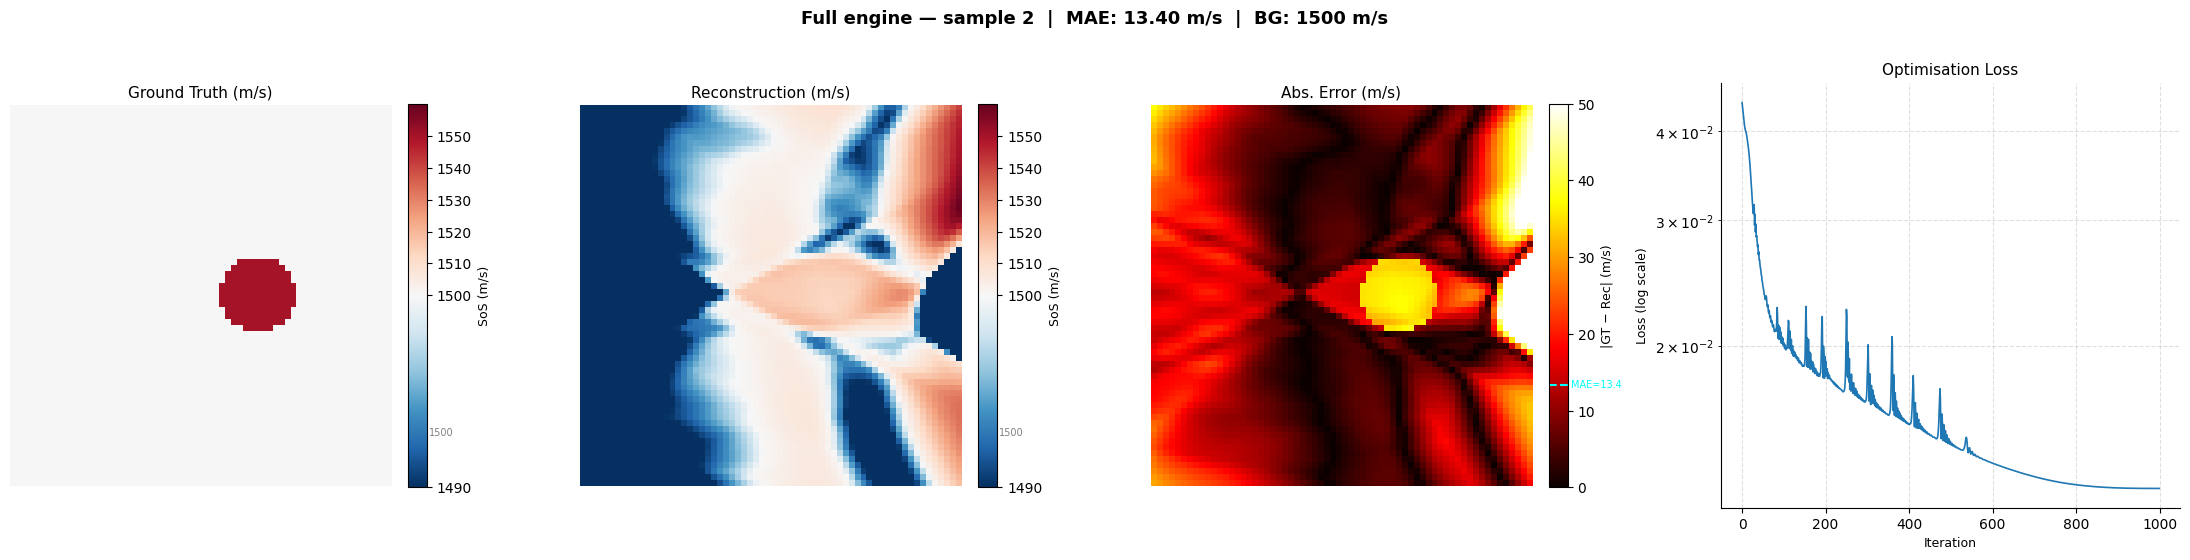

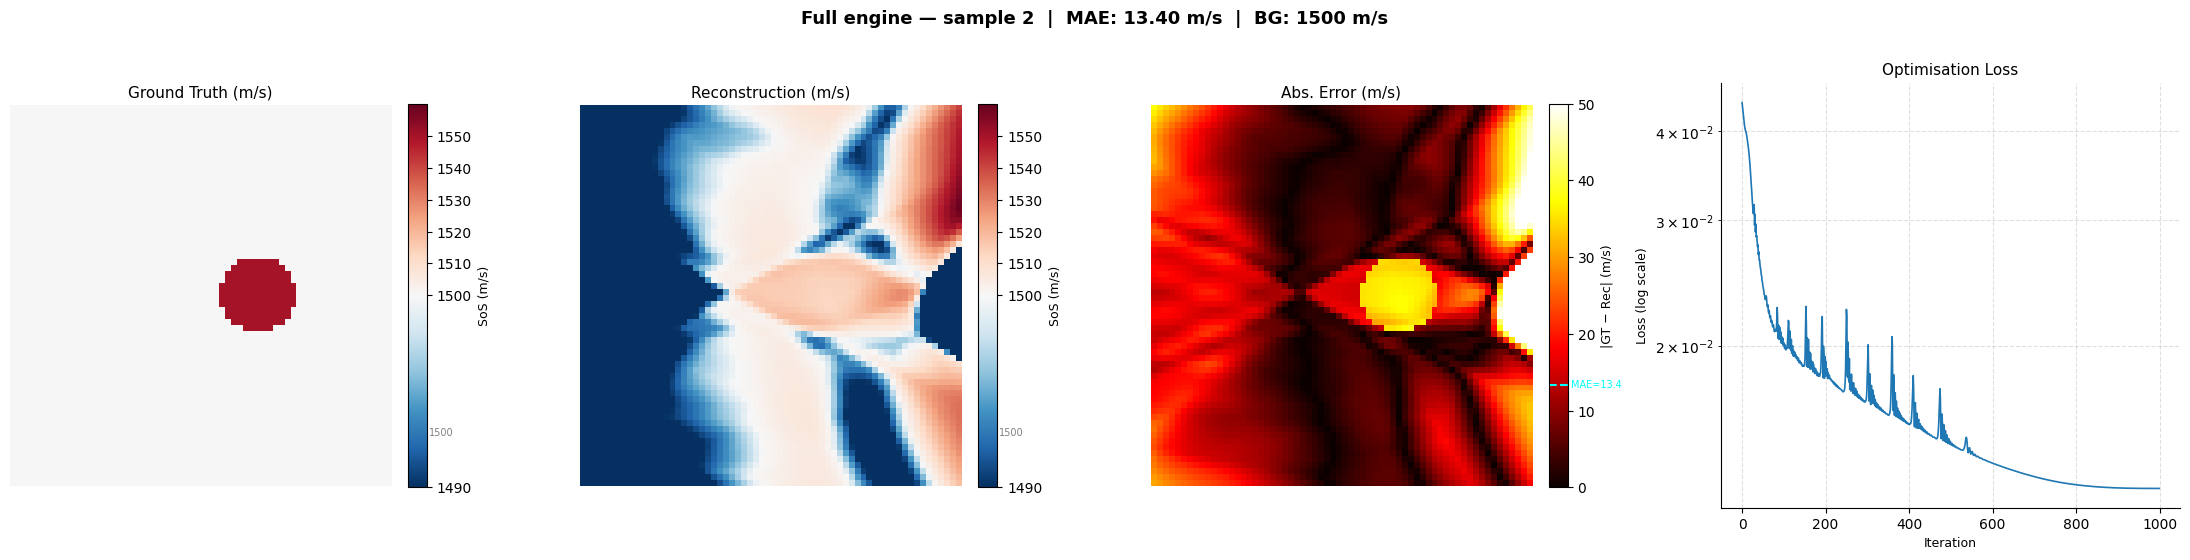

In [95]:
from inr_sos.visualization.plot_reconstruction import plot as plot_recon
plot_recon(result, sample, title=f"Full engine — sample {SAMPLE_IDX}")

---
## 9 — Compare against embedded L1/L2 baselines

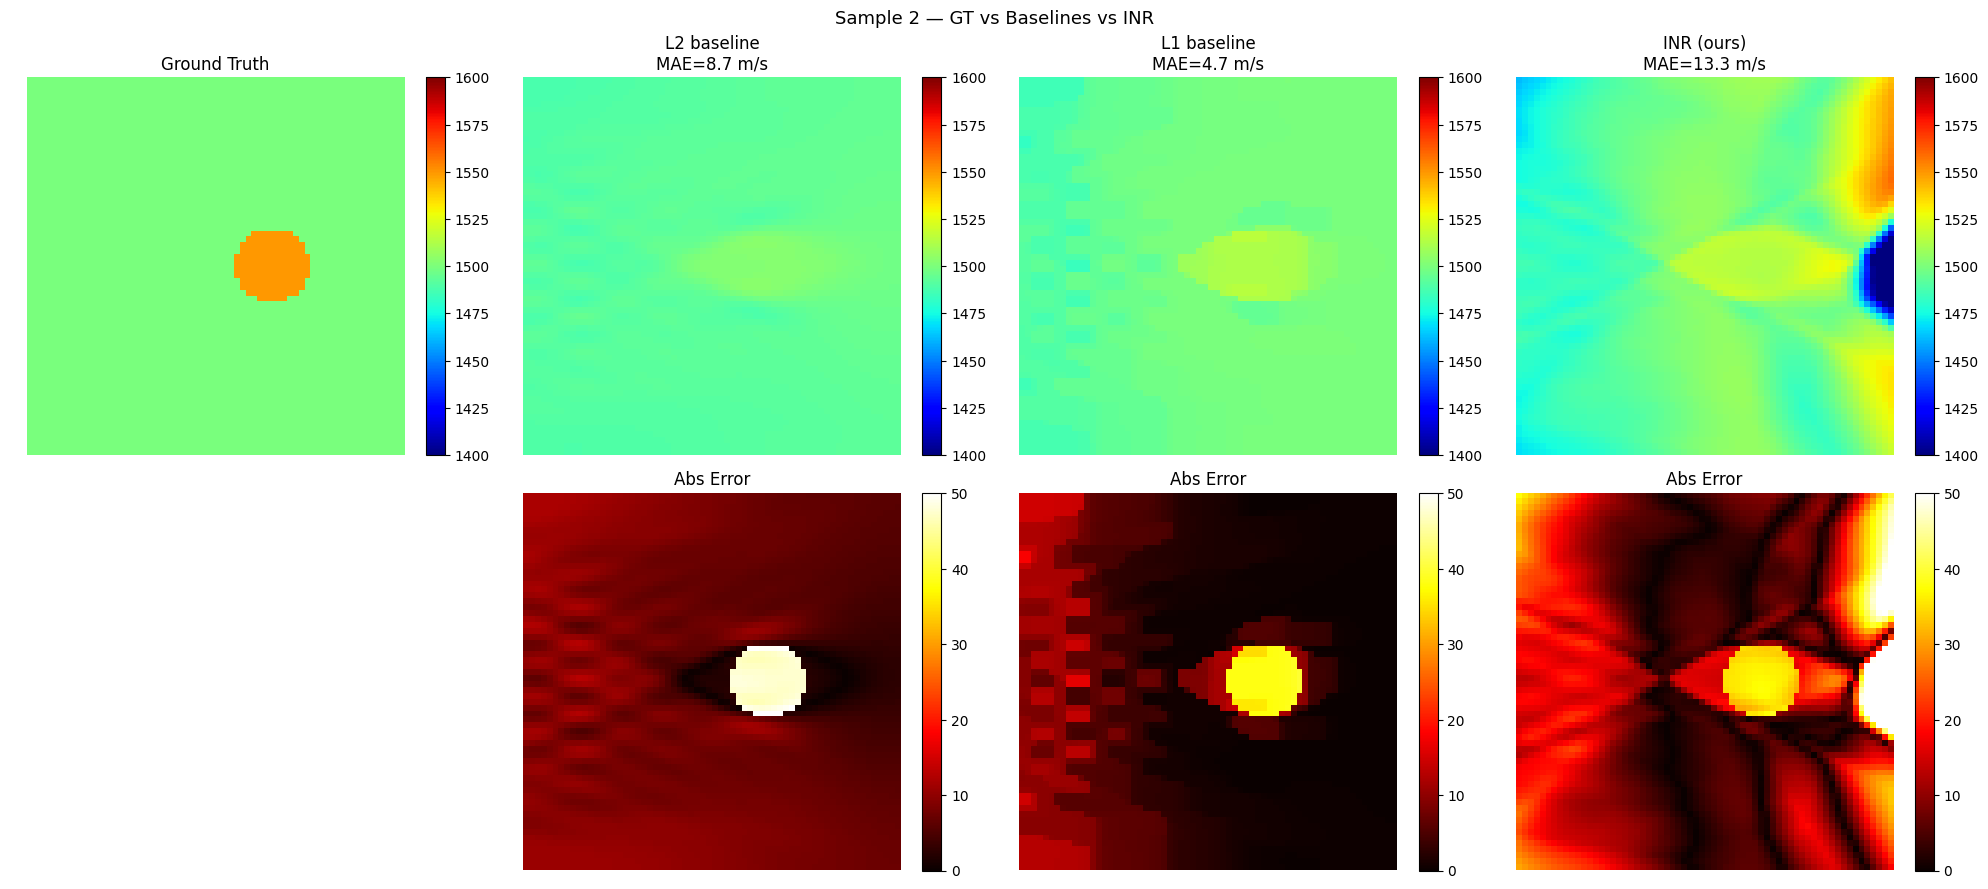

── Metric comparison ───────────────────────────
  L2 baseline     : MAE=8.69  RMSE=11.39  SSIM=0.796  CNR=3.409
  L1 baseline     : MAE=4.69  RMSE=8.60  SSIM=0.716  CNR=3.204
  INR (ours)      : MAE=13.58  RMSE=21.34  SSIM=0.739  CNR=0.928


In [96]:
if 's_l2_recon' in sample and 's_l1_recon' in sample:
    s_l2    = sample['s_l2_recon'].numpy().reshape(64, 64)
    s_l1    = sample['s_l1_recon'].numpy().reshape(64, 64)
    s_gt_np = sample['s_gt_raw'].numpy().reshape(64, 64)
    s_inr   = result['s_phys'].numpy().reshape(64, 64)

    methods = {
        'Ground Truth': s_gt_np,
        'L2 baseline' : s_l2,
        'L1 baseline' : s_l1,
        'INR (ours)'  : s_inr,
    }

    v_gt_np = 1.0 / (s_gt_np + 1e-8)

    fig, axes = plt.subplots(2, len(methods), figsize=(5 * len(methods), 9))
    fig.suptitle(f"Sample {SAMPLE_IDX} — GT vs Baselines vs INR", fontsize=13)

    for col, (label, s_map) in enumerate(methods.items()):
        v_map = 1.0 / (s_map + 1e-8)
        err   = np.abs(np.clip(v_map, 1400, 1600) - v_gt_np)
        mae_v = err.mean() if label != 'Ground Truth' else 0.0

        im0 = axes[0, col].imshow(np.clip(v_map, 1400, 1600), cmap='jet', vmin=1400, vmax=1600)
        axes[0, col].set_title(f"{label}" + (f"\nMAE={mae_v:.1f} m/s" if label != 'Ground Truth' else ""))
        axes[0, col].axis('off')
        plt.colorbar(im0, ax=axes[0, col], fraction=0.046)

        if label != 'Ground Truth':
            im1 = axes[1, col].imshow(err, cmap='hot', vmin=0, vmax=50)
            axes[1, col].set_title("Abs Error")
            plt.colorbar(im1, ax=axes[1, col], fraction=0.046)
        axes[1, col].axis('off')

    plt.tight_layout()
    plt.show()

    print("── Metric comparison ───────────────────────────")
    for label, s_map in methods.items():
        if label == 'Ground Truth':
            continue
        m = calculate_metrics(s_map.flatten(), s_gt_np.flatten(), grid_shape=(64,64))
        print(f"  {label:<16}: MAE={m['MAE']:.2f}  RMSE={m['RMSE']:.2f}  "
              f"SSIM={m['SSIM']:.3f}  CNR={m['CNR']:.3f}")
else:
    print("No embedded baselines found — skip.")

---
# Part II — Regularization Experiments

### Why the IC-tuned configs fail on k-wave

The W&B sweep was run entirely on IC data with `time_scale=1e6`.  
On k-wave data `time_scale ≈ 2e7` (20× larger). The data loss therefore drives  
gradients that are ~400× stronger, and the TV weight that balanced things on IC  
is now orders of magnitude too weak — producing the wave-like artifact patterns  
we saw in the comparison grid.

**Plan:**
1. `Cell 10` — helper `run_config()` + `plot_sweep_grid()`
2. `Cell 11` — sweep TV weight across 4 decades on a single sample
3. `Cell 12` — sweep number of steps at the best TV value
4. `Cell 13` — compare Full_Matrix vs Sequential_SGD at the best config
5. `Cell 14` — validate on 4 diverse samples, compare against L1/L2 baselines
6. `Cell 15` — loss curve analysis to check convergence
7. `Cell 16` — clean summary table + best config printout

---
## 10 — Helpers: `run_config` and `plot_sweep_grid`

In [97]:
import copy, time
import numpy as np
import torch
import matplotlib.pyplot as plt
from inr_sos.training.engines import optimize_full_forward_operator, optimize_sequential_views
from inr_sos.utils.config import ExperimentConfig
from inr_sos.evaluation.metrics import calculate_metrics
from inr_sos.models.mlp import ReluMLP

DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TIME_SCALE = 1.0 / dataset.pix2time
print(f'TIME_SCALE = {TIME_SCALE:.4e}  (device: {DEVICE})')

# ── Best IC architecture (rank4 Full_Matrix from W&B sweep) ─────────────────
BASE_CFG = dict(
    model_type      = 'ReluMLP',
    hidden_features = 512,
    hidden_layers   = 4,
    lr              = 6.52e-4,
    steps           = 1000,
    time_scale      = TIME_SCALE,
    reg_weight      = 1.87e-6,
    tv_weight       = 1.87e-6,   # IC-optimized — will be swept
)


def run_config(sample, overrides: dict, engine: str = 'full', seed: int = 0) -> dict:
    """
    Run one config on one sample. Returns dict with keys:
      metrics, result, cfg, elapsed, label

    Parameters
    ----------
    sample    : dataset item (dict)
    overrides : fields to override in BASE_CFG
    engine    : 'full' = Full_Matrix  |  'seq' = Sequential_SGD
    """
    torch.manual_seed(seed)
    cfg_dict = {**BASE_CFG, **overrides}
    cfg      = ExperimentConfig(**cfg_dict)

    model = ReluMLP(
        in_features     = cfg.in_features,
        hidden_features = cfg.hidden_features,
        hidden_layers   = cfg.hidden_layers,
    )

    engine_fn = (optimize_full_forward_operator
                 if engine == 'full' else optimize_sequential_views)

    t0     = time.perf_counter()
    result = engine_fn(
        sample   = sample,
        L_matrix = dataset.L_matrix,
        model    = model,
        label    = cfg.model_type,
        config   = cfg,
        use_wandb= False,
    )
    elapsed = time.perf_counter() - t0

    metrics = calculate_metrics(
        s_phys_pred = result['s_phys'],
        s_gt_raw    = sample['s_gt_raw'],
        grid_shape  = (64, 64),
    )
    return {'metrics': metrics, 'result': result,
            'cfg': cfg_dict, 'elapsed': elapsed}


def plot_sweep_grid(sweep_results: list, ref_sample, title: str):
    """
    For each config in sweep_results plot SoS reconstruction (top row)
    and absolute error vs GT (bottom row).
    Each dict in sweep_results must have a 'label' key.
    """
    n    = len(sweep_results)
    v_gt = 1.0 / (ref_sample['s_gt_raw'].numpy().reshape(64, 64) + 1e-8)

    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))
    if n == 1:
        axes = axes.reshape(2, 1)
    fig.suptitle(title, fontsize=11, fontweight='bold')

    for col, r in enumerate(sweep_results):
        s_phys = r['result']['s_phys'].numpy().reshape(64, 64)
        v_pred = np.clip(1.0 / (s_phys + 1e-8), 1400, 1600)
        err    = np.abs(v_pred - v_gt)
        mae    = r['metrics']['MAE']
        ssim   = r['metrics']['SSIM']
        label  = r.get('label', str(col))

        im0 = axes[0, col].imshow(v_pred, cmap='jet', vmin=1400, vmax=1600)
        axes[0, col].set_title(f'{label}\nMAE={mae:.1f}  SSIM={ssim:.3f}', fontsize=8)
        axes[0, col].axis('off')
        plt.colorbar(im0, ax=axes[0, col], fraction=0.046)

        im1 = axes[1, col].imshow(err, cmap='hot', vmin=0, vmax=50)
        axes[1, col].set_title('Abs Error (m/s)', fontsize=8)
        axes[1, col].axis('off')
        plt.colorbar(im1, ax=axes[1, col], fraction=0.046)

    plt.tight_layout()
    plt.show()


print('Helpers ready.')

TIME_SCALE = 2.0133e+07  (device: cuda)
Helpers ready.


---
## 11 — TV weight sweep (single sample)

IC-optimised TV was ~1e-6.  
k-wave data loss is ~400× stronger, so we expect the sweet spot around **1e-4 – 1e-2**.

In [98]:
sample = dataset[SAMPLE_IDX]

TV_VALUES = [1e-6, 1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 0]

tv_sweep_results = []
for tv in TV_VALUES:
    print(f'  tv_weight={tv:.0e} ...', end=' ', flush=True)
    r = run_config(sample, overrides={'tv_weight': tv})
    r['label'] = f'tv={tv:.0e}'
    tv_sweep_results.append(r)
    m = r['metrics']
    print(f"MAE={m['MAE']:.2f}  SSIM={m['SSIM']:.3f}  "
          f"CNR={m['CNR']:.3f}  ({r['elapsed']:.0f}s)")

  tv_weight=1e-06 ... 

Loss (us^2): 0.0113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.16it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=22.97  SSIM=0.761  CNR=0.197  (11s)
  tv_weight=1e-05 ... 


Loss (us^2): 0.0113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.30it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=22.97  SSIM=0.761  CNR=0.197  (11s)
  tv_weight=1e-04 ... 


Loss (us^2): 0.0113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.04it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=22.97  SSIM=0.761  CNR=0.197  (11s)
  tv_weight=1e-03 ... 


Loss (us^2): 0.0113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.75it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=22.96  SSIM=0.761  CNR=0.197  (11s)
  tv_weight=5e-03 ... 


Loss (us^2): 0.0113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.67it/s, method=optimize_full_forward_operator, model=ReluMLP]


MAE=22.96  SSIM=0.761  CNR=0.182  (11s)
  tv_weight=1e-02 ... 

Loss (us^2): 0.0112: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.40it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=23.68  SSIM=0.755  CNR=0.209  (11s)
  tv_weight=0e+00 ... 


Loss (us^2): 0.0113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.67it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=22.97  SSIM=0.761  CNR=0.197  (11s)


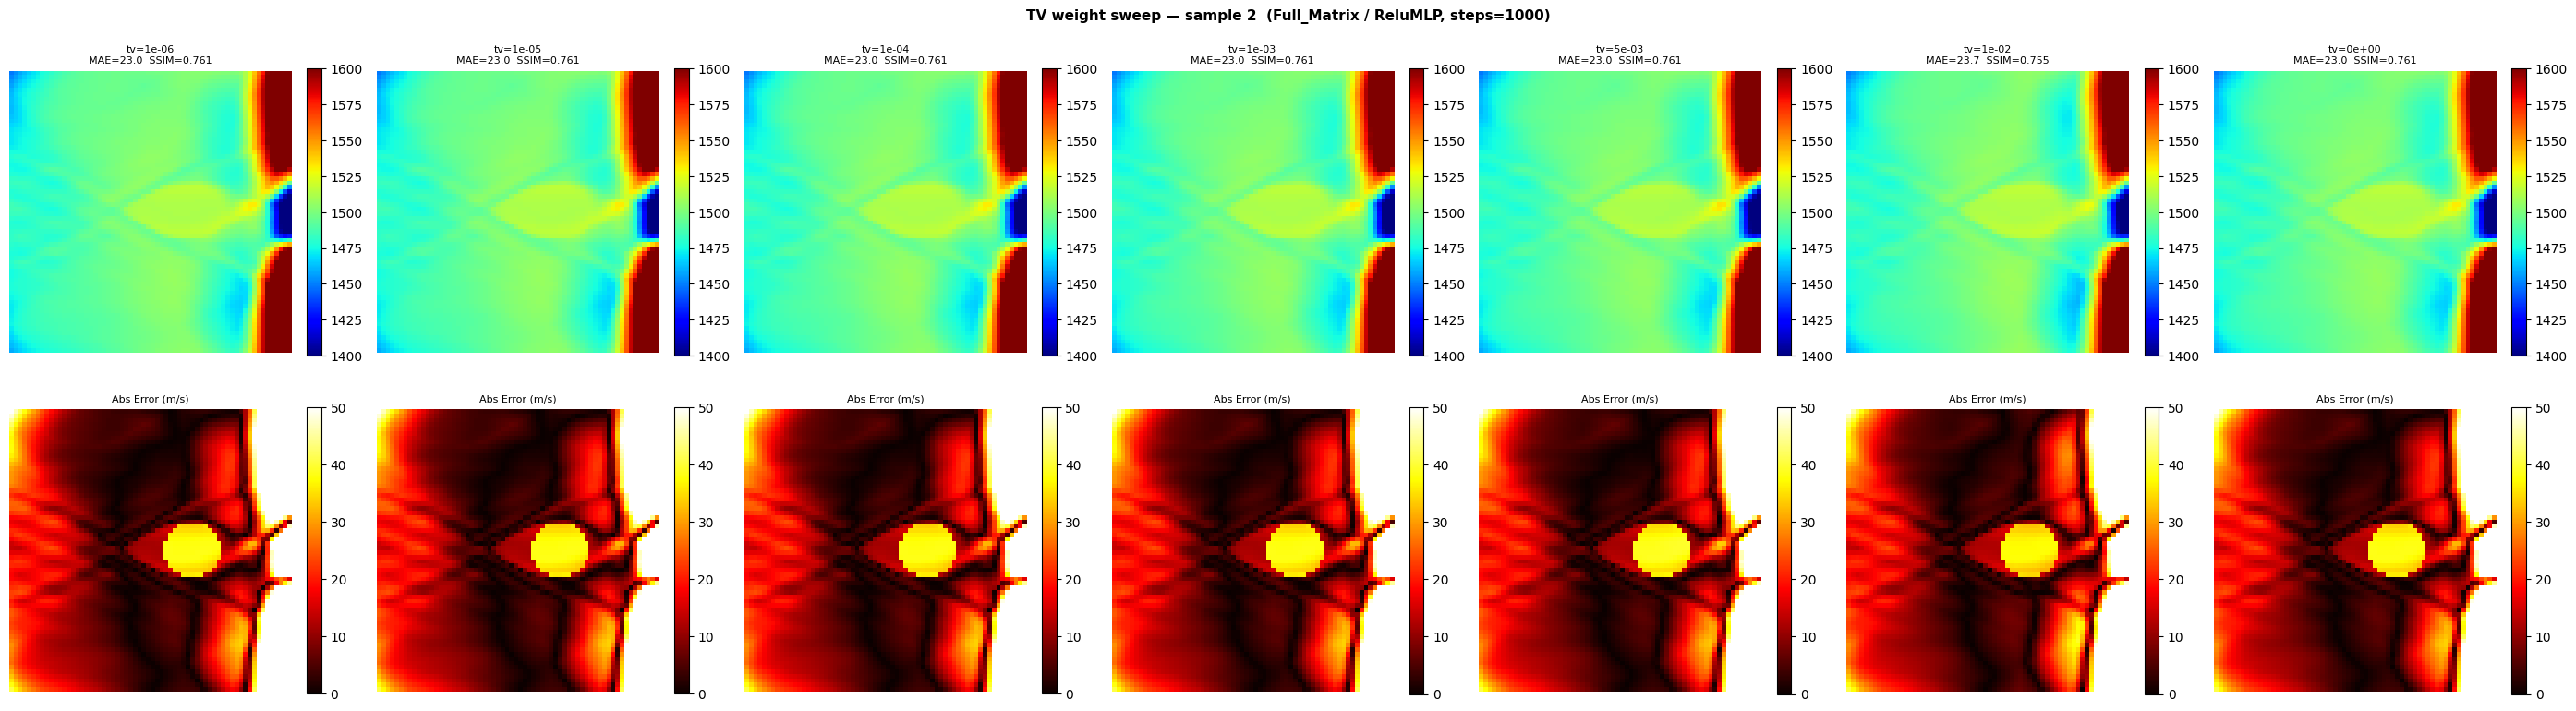

tv_weight        MAE     RMSE    SSIM     CNR
------------------------------------------------
1e-06          22.97    44.46   0.761   0.197
1e-05          22.97    44.46   0.761   0.197
1e-04          22.97    44.46   0.761   0.197
1e-03          22.96    44.47   0.761   0.197
5e-03          22.96    44.42   0.761   0.182
1e-02          23.68    45.91   0.755   0.209
0e+00          22.97    44.46   0.761   0.197

→ Best MAE at tv_weight = 5e-03  (MAE=22.96)


In [99]:
plot_sweep_grid(
    tv_sweep_results, sample,
    f'TV weight sweep — sample {SAMPLE_IDX}  (Full_Matrix / ReluMLP, steps=1000)'
)

# ── Summary table ────────────────────────────────────────────────────────────
print(f"{'tv_weight':<12} {'MAE':>7} {'RMSE':>8} {'SSIM':>7} {'CNR':>7}")
print('-' * 48)
for r in tv_sweep_results:
    m = r['metrics']
    print(f"{r['cfg']['tv_weight']:<12.0e} {m['MAE']:>7.2f} "
          f"{m['RMSE']:>8.2f} {m['SSIM']:>7.3f} {m['CNR']:>7.3f}")

best_tv_run = min(tv_sweep_results, key=lambda x: x['metrics']['MAE'])
BEST_TV     = best_tv_run['cfg']['tv_weight']
print(f"\n→ Best MAE at tv_weight = {BEST_TV:.0e}  "
      f"(MAE={best_tv_run['metrics']['MAE']:.2f})")

---
## 12 — SIREN vs ReluMLP × learning rate sweep

### Why TV failed
Cell 11 showed TV has no effect from 1e-6 → 1e-3. The data loss gradient  
(time_scale ≈ 2e7, 20× the IC value) dominates completely — TV never competes.  
The artifacts are **structured physics-mismatch residuals** that ReluMLP faithfully  
represents because it has no spectral bias against high-frequency content.

### Two levers that actually matter
1. **Architecture — SIREN**: sine activations impose a smooth inductive bias.  
   High-frequency artifacts cost more to represent, so the network preferentially  
   keeps the low-frequency inclusion and suppresses background noise.
2. **Learning rate**: with gradients ~400× stronger than IC, the IC-tuned lr=6.5e-4  
   is effectively very large. A lower lr slows convergence into the artifact basin.

### Plan
- 3×2 grid: `{ReluMLP, SIREN}` × `{lr: 6.5e-4, 1e-4, 1e-5}`
- Plus SIREN with 2000 steps since it converges slower
- TV fixed at 1e-6 (IC default) — test architecture first, revisit TV after

In [51]:
from inr_sos.models.siren import SirenMLP
from inr_sos.models.mlp import FourierMLP

def run_config_arch(sample, model_type: str, lr: float,
                    steps: int = 1000,
                    tv_weight: float = 1e-6,
                    hidden_features: int = 256,
                    hidden_layers: int = 3,
                    seed: int = 0) -> dict:
    """
    Like run_config() but also handles SIREN model instantiation.
    model_type: 'ReluMLP' or 'SIREN'
    """
    torch.manual_seed(seed)
    cfg = ExperimentConfig(
        model_type      = model_type,
        hidden_features = hidden_features,
        hidden_layers   = hidden_layers,
        lr              = lr,
        steps           = steps,
        time_scale      = TIME_SCALE,
        tv_weight       = tv_weight,
        reg_weight      = 0.0,
    )

    if model_type == 'SIREN':
        model = SIREN_Network(
            in_features     = 2,
            hidden_features = hidden_features,
            hidden_layers   = hidden_layers,
            out_features    = 1,
        )
    else:
        model = ReluMLP(
            in_features     = cfg.in_features,
            hidden_features = hidden_features,
            hidden_layers   = hidden_layers,
        )

    t0     = time.perf_counter()
    result = optimize_full_forward_operator(
        sample   = sample,
        L_matrix = dataset.L_matrix,
        model    = model,
        label    = model_type,
        config   = cfg,
        use_wandb= False,
    )
    elapsed = time.perf_counter() - t0

    metrics = calculate_metrics(
        s_phys_pred = result['s_phys'],
        s_gt_raw    = sample['s_gt_raw'],
        grid_shape  = (64, 64),
    )
    return {'metrics': metrics, 'result': result,
            'model_type': model_type, 'lr': lr, 'steps': steps,
            'elapsed': elapsed}

print('run_config_arch ready.')

run_config_arch ready.


In [52]:
ARCH_CONFIGS = [
    # (label,                  model_type,  lr,      steps)
    ('ReLU  lr=6.5e-4',       'ReluMLP',  6.52e-4, 1000),
    ('ReLU  lr=1e-4',         'ReluMLP',  1e-4,    1000),
    ('ReLU  lr=1e-5',         'ReluMLP',  1e-5,    1000),
    ('SIREN lr=6.5e-4',       'SIRENMLP',    6.52e-4, 1000),
    ('SIREN lr=1e-4',         'SIRENMLP',    1e-4,    1000),
    ('SIREN lr=1e-5',         'SIRENMLP',    1e-5,    1000),
    ('SIREN lr=1e-4 s=2000',  'SIRENMLP',    1e-4,    2000),
    ('FourierReLU  lr=6.5e-4', 'FourierMLP',  6.52e-4, 1000),
    ('FourierReLU  lr=1e-4',   'FourierMLP',  1e-4,    1000),
    ('FourierReLU  lr=1e-5',   'FourierMLP',  1e-5,    1000),
]

arch_results = []
for label, mtype, lr, steps in ARCH_CONFIGS:
    print(f'  {label} ...', end=' ', flush=True)
    r = run_config_arch(sample, model_type=mtype, lr=lr, steps=steps)
    r['label'] = label
    arch_results.append(r)
    m = r['metrics']
    print(f"MAE={m['MAE']:.2f}  SSIM={m['SSIM']:.3f}  "
          f"CNR={m['CNR']:.3f}  ({r['elapsed']:.0f}s)")

  ReLU  lr=6.5e-4 ... 

Loss (us^2): 0.0107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.54it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=38.16  SSIM=0.761  CNR=0.460  (9s)
  ReLU  lr=1e-4 ... 


Loss (us^2): 0.0138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.88it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=31.94  SSIM=0.762  CNR=0.466  (9s)
  ReLU  lr=1e-5 ... 


Loss (us^2): 0.0264: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.98it/s, method=optimize_full_forward_operator, model=ReluMLP]

MAE=9.85  SSIM=0.529  CNR=1.205  (9s)
  SIREN lr=6.5e-4 ... 


Loss (us^2): 0.0107: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.74it/s, method=optimize_full_forward_operator, model=SIRENMLP]

MAE=38.16  SSIM=0.761  CNR=0.460  (9s)
  SIREN lr=1e-4 ... 


Loss (us^2): 0.0138: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.24it/s, method=optimize_full_forward_operator, model=SIRENMLP]


MAE=31.94  SSIM=0.762  CNR=0.466  (9s)
  SIREN lr=1e-5 ... 

Loss (us^2): 0.0264: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.99it/s, method=optimize_full_forward_operator, model=SIRENMLP]

MAE=9.85  SSIM=0.529  CNR=1.205  (9s)
  SIREN lr=1e-4 s=2000 ... 


Loss (us^2): 0.0105: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 110.89it/s, method=optimize_full_forward_operator, model=SIRENMLP]


MAE=38.65  SSIM=0.750  CNR=0.440  (18s)
  FourierReLU  lr=6.5e-4 ... 

Loss (us^2): 0.0107: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.58it/s, method=optimize_full_forward_operator, model=FourierMLP]

MAE=38.16  SSIM=0.761  CNR=0.460  (9s)
  FourierReLU  lr=1e-4 ... 


Loss (us^2): 0.0138: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.16it/s, method=optimize_full_forward_operator, model=FourierMLP]

MAE=31.94  SSIM=0.762  CNR=0.466  (9s)
  FourierReLU  lr=1e-5 ... 


Loss (us^2): 0.0264: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.22it/s, method=optimize_full_forward_operator, model=FourierMLP]

MAE=9.85  SSIM=0.529  CNR=1.205  (9s)


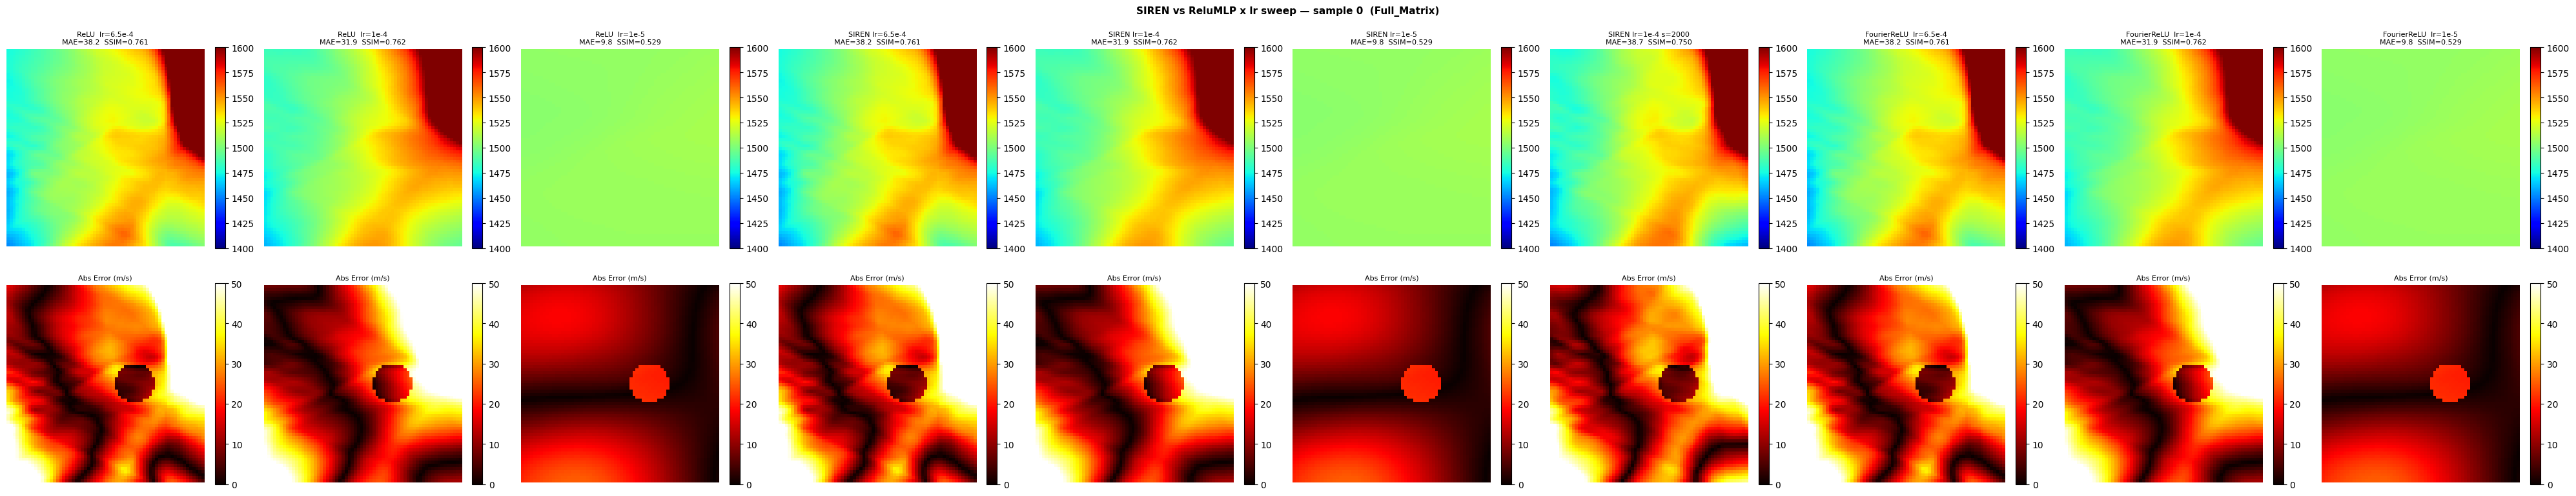

label                          MAE     RMSE    SSIM     CNR  steps
-----------------------------------------------------------------
ReLU  lr=6.5e-4              38.16    72.80   0.761   0.460  1000
ReLU  lr=1e-4                31.94    52.84   0.762   0.466  1000
ReLU  lr=1e-5                 9.85    11.94   0.529   1.205  1000
SIREN lr=6.5e-4              38.16    72.80   0.761   0.460  1000
SIREN lr=1e-4                31.94    52.84   0.762   0.466  1000
SIREN lr=1e-5                 9.85    11.94   0.529   1.205  1000
SIREN lr=1e-4 s=2000         38.65    71.28   0.750   0.440  2000
FourierReLU  lr=6.5e-4       38.16    72.80   0.761   0.460  1000
FourierReLU  lr=1e-4         31.94    52.84   0.762   0.466  1000
FourierReLU  lr=1e-5          9.85    11.94   0.529   1.205  1000

-> Best: ReLU  lr=1e-5  MAE=9.85


In [53]:
plot_sweep_grid(
    arch_results, sample,
    'SIREN vs ReluMLP x lr sweep — sample 0  (Full_Matrix)'
)

print(f"{'label':<26} {'MAE':>7} {'RMSE':>8} {'SSIM':>7} {'CNR':>7}  steps")
print('-' * 65)
for r in arch_results:
    m = r['metrics']
    print(f"{r['label']:<26} {m['MAE']:>7.2f} {m['RMSE']:>8.2f} "
          f"{m['SSIM']:>7.3f} {m['CNR']:>7.3f}  {r['steps']}")

best_arch       = min(arch_results, key=lambda x: x['metrics']['MAE'])
BEST_MODEL_TYPE = best_arch['model_type']
BEST_LR         = best_arch['lr']
BEST_STEPS      = best_arch['steps']
print(f"\n-> Best: {best_arch['label']}  MAE={best_arch['metrics']['MAE']:.2f}")

/tmp/ipykernel_1944007/2386006746.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7)


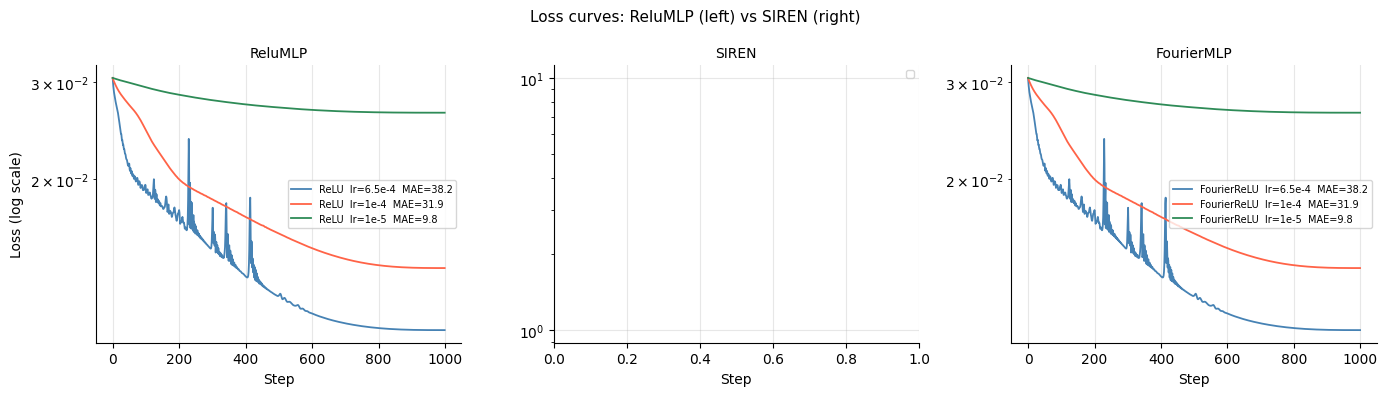


Interpretation guide:
  ReluMLP curves all converge to same loss      -> data loss dominates, lr irrelevant
  SIREN curves separate clearly by lr           -> lr controls implicit regularization
  SIREN final loss higher than ReluMLP          -> SIREN is regularizing (good)
  SIREN final loss same as ReluMLP              -> SIREN also overfitting to artifacts



In [56]:
# Loss curves: ReluMLP vs SIREN side-by-side
relu_runs  = [r for r in arch_results if r['model_type'] == 'ReluMLP']
siren_runs = [r for r in arch_results if r['model_type'] == 'SIREN']
fourier_runs = [r for r in arch_results if r['model_type'] == 'FourierMLP']


fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Loss curves: ReluMLP (left) vs SIREN (right)', fontsize=11)

colors = ['steelblue', 'tomato', 'seagreen', 'darkorange']
for ax, runs, title in [(axes[0], relu_runs, 'ReluMLP'),
                         (axes[1], siren_runs, 'SIREN'),
                         (axes[2], fourier_runs, 'FourierMLP')]:
    for i, r in enumerate(runs):
        hist = r['result']['loss_history']
        ax.plot(hist,
                label=f"{r['label']}  MAE={r['metrics']['MAE']:.1f}",
                color=colors[i % len(colors)], linewidth=1.3)
    ax.set_yscale('log')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Step')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_ylabel('Loss (log scale)')
plt.tight_layout()
plt.show()

print("""
Interpretation guide:
  ReluMLP curves all converge to same loss      -> data loss dominates, lr irrelevant
  SIREN curves separate clearly by lr           -> lr controls implicit regularization
  SIREN final loss higher than ReluMLP          -> SIREN is regularizing (good)
  SIREN final loss same as ReluMLP              -> SIREN also overfitting to artifacts
""")

---
## 13 — Full_Matrix vs Sequential_SGD at best config

The IC sweep favoured Sequential_SGD for ranks 1, 2, 3, 5.  
On k-wave the L-matrix captures full-wave physics in the A matrix —  
check whether Full_Matrix (which uses the whole L at once) has an edge.

In [ ]:
print(f'Config: tv={BEST_TV:.0e}, steps={BEST_STEPS}\n')

engine_results = []
for label, key in [('Full_Matrix', 'full'), ('Sequential_SGD', 'seq')]:
    print(f'  {label} ...', end=' ', flush=True)
    r = run_config(sample, overrides={'tv_weight': BEST_TV, 'steps': BEST_STEPS}, engine=key)
    r['label'] = label
    engine_results.append(r)
    m = r['metrics']
    print(f"MAE={m['MAE']:.2f}  SSIM={m['SSIM']:.3f}  "
          f"CNR={m['CNR']:.3f}  ({r['elapsed']:.0f}s)")

plot_sweep_grid(
    engine_results, sample,
    f'Engine comparison — tv={BEST_TV:.0e}, steps={BEST_STEPS}'
)

BEST_ENGINE     = min(engine_results, key=lambda x: x['metrics']['MAE'])['label']
BEST_ENGINE_KEY = 'full' if BEST_ENGINE == 'Full_Matrix' else 'seq'
print(f'\n→ Best engine: {BEST_ENGINE}')

---
## 14 — Multi-sample validation

Confirm the single-sample findings generalise across 4 diverse samples and  
report metrics side-by-side with the embedded L1 / L2 baselines.

In [ ]:
print(f'Best config → engine={BEST_ENGINE}  tv={BEST_TV:.0e}  steps={BEST_STEPS}\n')

# Indices chosen to span different inclusion positions and bg SoS values
MULTI_INDICES = [0, 5, 10, 19]

all_metrics   = {'MAE': [], 'RMSE': [], 'SSIM': [], 'CNR': []}
l1_metrics_ms = {'MAE': [], 'RMSE': [], 'SSIM': [], 'CNR': []}
l2_metrics_ms = {'MAE': [], 'RMSE': [], 'SSIM': [], 'CNR': []}
multi_results = []

for idx in MULTI_INDICES:
    s = dataset[idx]
    print(f'  sample {idx} ...', end=' ', flush=True)

    r = run_config(
        s,
        overrides={'tv_weight': BEST_TV, 'steps': BEST_STEPS},
        engine=BEST_ENGINE_KEY,
    )
    r['label']  = f'INR s{idx}'
    r['sample'] = s
    multi_results.append(r)

    m = r['metrics']
    for k in all_metrics:
        all_metrics[k].append(m[k])

    # Baseline metrics on the same sample
    s_gt_flat = s['s_gt_raw'].numpy().flatten()
    for key, store in [('s_l1_recon', l1_metrics_ms), ('s_l2_recon', l2_metrics_ms)]:
        if key in s:
            bm = calculate_metrics(s[key].numpy().flatten(), s_gt_flat, (64, 64))
            for k in store:
                store[k].append(bm[k])

    print(f"MAE={m['MAE']:.2f}  SSIM={m['SSIM']:.3f}  CNR={m['CNR']:.3f}")

In [ ]:
# ── Visual grid: GT | L2 | L1 | INR for all 4 samples ───────────────────────
col_labels = ['Ground Truth', 'L2 baseline', 'L1 baseline', f'INR ({BEST_ENGINE})']
fig, axes  = plt.subplots(len(MULTI_INDICES), 4, figsize=(20, 5 * len(MULTI_INDICES)))
fig.suptitle(
    f'Multi-sample: GT vs L2 vs L1 vs INR  '
    f'(tv={BEST_TV:.0e}, steps={BEST_STEPS}, {BEST_ENGINE})',
    fontsize=12, fontweight='bold'
)

for col, t in enumerate(col_labels):
    axes[0, col].set_title(t, fontsize=10, fontweight='bold')

for row, (idx, r) in enumerate(zip(MULTI_INDICES, multi_results)):
    s     = r['sample']
    s_gt  = s['s_gt_raw'].numpy().reshape(64, 64)
    s_inr = r['result']['s_phys'].numpy().reshape(64, 64)
    s_l2  = s['s_l2_recon'].numpy().reshape(64, 64) if 's_l2_recon' in s else s_gt
    s_l1  = s['s_l1_recon'].numpy().reshape(64, 64) if 's_l1_recon' in s else s_gt
    v_gt  = 1.0 / (s_gt + 1e-8)

    for col, s_map in enumerate([s_gt, s_l2, s_l1, s_inr]):
        v    = np.clip(1.0 / (s_map + 1e-8), 1400, 1600)
        mae_v = np.abs(v - v_gt).mean() if col > 0 else 0.0
        im   = axes[row, col].imshow(v, cmap='jet', vmin=1400, vmax=1600)
        if col > 0:
            axes[row, col].set_xlabel(f'MAE={mae_v:.1f} m/s', fontsize=8)
        if col == 0:
            axes[row, col].set_ylabel(f'sample {idx}', fontsize=9)
        axes[row, col].axis('off')
        plt.colorbar(im, ax=axes[row, col], fraction=0.046)

plt.tight_layout()
plt.show()

---
## 15 — Loss curve analysis

Check whether the loss has flattened by the final step.  
A still-falling curve means more steps would help; a flat/rising curve  
means we have converged (or are starting to overfit).

In [ ]:
fig, axes = plt.subplots(1, len(MULTI_INDICES), figsize=(5 * len(MULTI_INDICES), 4))
fig.suptitle(f'Loss curves — tv={BEST_TV:.0e}, steps={BEST_STEPS}', fontsize=12)

for col, (idx, r) in enumerate(zip(MULTI_INDICES, multi_results)):
    hist = r['result']['loss_history']
    axes[col].plot(hist, color='steelblue', linewidth=1.2)
    axes[col].set_yscale('log')
    axes[col].set_title(f"sample {idx}  MAE={r['metrics']['MAE']:.1f}", fontsize=9)
    axes[col].set_xlabel('Step')
    axes[col].grid(True, alpha=0.3)
    axes[col].spines['top'].set_visible(False)
    axes[col].spines['right'].set_visible(False)

    # Annotate final slope — still falling or flat?
    if len(hist) >= 100:
        tail  = hist[-100:]
        slope = (tail[-1] - tail[0]) / tail[0] * 100
        axes[col].set_xlabel(
            f'Step\ntail change: {slope:+.1f}%', fontsize=8
        )

axes[0].set_ylabel('Loss (log scale)')
plt.tight_layout()
plt.show()

---
## 16 — Summary table + best config

Print the final comparison table and emit the best config dict  
ready to paste into `compare_topk.py` or a new W&B sweep.

In [ ]:
def _mean_std(lst):
    return np.mean(lst), np.std(lst)

print('═' * 68)
print(f"  {'Method':<24} {'MAE':>8} {'RMSE':>8} {'SSIM':>7} {'CNR':>7}")
print('─' * 68)

# INR row
mu, sd = _mean_std(all_metrics['MAE'])
print(f"  {'INR (notebook best)':<24} {mu:>6.2f}±{sd:<4.2f} "
      f"{_mean_std(all_metrics['RMSE'])[0]:>8.2f} "
      f"{_mean_std(all_metrics['SSIM'])[0]:>7.3f} "
      f"{_mean_std(all_metrics['CNR'])[0]:>7.3f}")

# Baseline rows
for name, store in [('L1 regularization', l1_metrics_ms),
                     ('L2 regularization', l2_metrics_ms)]:
    if store['MAE']:
        mu, sd = _mean_std(store['MAE'])
        print(f"  {name:<24} {mu:>6.2f}±{sd:<4.2f} "
              f"{_mean_std(store['RMSE'])[0]:>8.2f} "
              f"{_mean_std(store['SSIM'])[0]:>7.3f} "
              f"{_mean_std(store['CNR'])[0]:>7.3f}")

print('═' * 68)

# Gap vs L1
if l1_metrics_ms['MAE']:
    gap = np.mean(all_metrics['MAE']) - np.mean(l1_metrics_ms['MAE'])
    pct = 100 * gap / np.mean(l1_metrics_ms['MAE'])
    direction = 'worse' if gap > 0 else 'better'
    print(f"\n  INR is {abs(pct):.1f}% {direction} than L1 on MAE")

print()
print('── Best config to use in compare_topk.py / new sweep ──────────────')
print(f"  engine         = '{BEST_ENGINE}'")
print(f"  time_scale     = {TIME_SCALE:.4e}  # from dataset.pix2time")
print(f"  tv_weight      = {BEST_TV:.2e}")
print(f"  steps          = {BEST_STEPS}")
print(f"  hidden_features= {BASE_CFG['hidden_features']}")
print(f"  hidden_layers  = {BASE_CFG['hidden_layers']}")
print(f"  lr             = {BASE_CFG['lr']:.2e}")
print(f"  reg_weight     = {BASE_CFG['reg_weight']:.2e}")